In [524]:
%load_ext autoreload
%autoreload 2
import sys
from glob import glob

from utils.simulation.simulation_utils import generateUnits, simulateTuningShift, simulateUnitActivity, sampleSNR
from utils.plotting.plotting_utils import figSize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression


import numpy as np
from numpy import *
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


def makeEncodingAsymmetric(n_units, SNR, strength=0):
    '''Induce asymmetries into encoding matrix. Inputs are:
    
      n_units (int)    - number of channels
      SNR (float)      - system SNR
      strength (int)   - 0: inf symmetry, 1: 2D symmetry, 
                         2: 1D symmetry,  3: no symmetry
      
      Returns:
          encoding (3D float) - channels x encoding weights (mean, x, y tuning)
      '''
    
    
    # first generate regular encoding
    encoding = generateUnits(n_units=n_units, SNR= SNR)
    encoding[:, 0] = 0
    orig_norm = np.linalg.norm(encoding[:, 1:])

    
    if strength == 0:
        return encoding
   
    elif strength == 1:
        encoding[:, 1] *= 2
        encoding[:, 2] *= 0.5
        
    elif strength == 2:
        encoding[:, 1] *= 2
        encoding[:, 2] *= 0.5
        
        idxs = np.random.choice(np.arange(n_units), int(n_units/5), replace=False)
        encoding[idxs,2] = np.random.normal(0.1, 0.001, size=len(idxs))
        
        #R = 1
        #theta = np.random.uniform(0,2*np.pi, encoding.shape[0])
        #radius = np.random.uniform(0,R, encoding.shape[0]) ** 0.5
        
        #encoding[:, 1] = radius * np.cos(theta) * 2
        #encoding[:, 2] = radius * np.sin(theta) * 0.5
        
        #idxs  = np.logical_and(encoding[:, 2] > 0.05, encoding[:, 1] > 0.)
        #idxs  = encoding[:, 2] > 0
        #vals  = encoding[idxs, 2]
        #vals  = np.linalg.norm(encoding[idxs, :], axis=1)
        #scale = vals #(vals - vals.min()) / (vals.max() - vals.min()) 
        
        #encoding[idxs, 1] -= scale * np.sign(encoding[idxs, 1])
        #encoding[idxs, 2] += 0.5 * (scale) #+ 0.05
        
    elif strength == 3:
        encoding[:, 1:] = makeSmiley()[['x', 'y']].to_numpy()
        
    else:
        raise ValueError('strength parameter must be in [0-4]')
        
    # recenter
    encoding[:, 1:] -= np.mean(encoding[:, 1:], axis = 0)

    # Rescale encoding subspace strength to compensate for any weirdness from asymmetric transforms
    if strength == 1:
        encoding[:, 1:] /=  np.mean(np.linalg.norm(encoding[:, 1:], axis=0))
    else:
        encoding[:, 1:] /= np.sqrt(2 * np.mean(np.linalg.norm(encoding[:, 1:], axis=0))**2)
        
    #asym_encoding[:, 1:] /= np.linalg.norm(asym_encoding[:, 1:])
    encoding[:, 1:] *= orig_norm

    return encoding


def makeSmiley(n_channels=192):


    # Initialize the DataFrame
    columns = ['x', 'y', 'l']
    df = pd.DataFrame(columns=columns)

    # Choose how many points to have in each class.
    L_points = 20 # left eye 
    R_points = 52 # nose
    S_points = 70 # smile
    B_points = 50 # circular brow
    fuzz = .05
    
    # Make the nose
    label = 'R'
    x_c = 0.
    y_c = 0.
    for _ in range(R_points):
        x = np.random.uniform(low=x_c, high=fuzz * 15)
        y = x * 1 if np.random.randint(2) else y_c
        #y = np.random.normal(loc=y_c, scale=fuzz)
        norm = np.sqrt(x**2 + y**2)
        
        rot  = -1 * np.pi / 8
        
        R    = np.asarray([[np.cos(rot), np.sin(rot)],[-1 * np.sin(rot), np.cos(rot)]])
        vals = np.asarray([x,y]).dot(R)
        x = vals[0]
        y = vals[1]
        
        x += 0.8
        y +=0.5
        df.loc[len(df.index)] = (x, y, label)
        
        
    # Make the left eye. Add random noise to make the points distinct.
    label = 'L'
    x_c = -1.5
    y_c = 1.
    for _ in range(L_points):
        x = np.random.normal(loc=x_c, scale=fuzz/2)
        y = np.random.normal(loc=y_c, scale=fuzz/2)
        df.loc[len(df.index)] = (x, y, label)

        

    # Make the smile as a segment of a circle.
    # Add random noise to make the points distinct.
    label = 'S'
    x_c = 1.
    y_c = 1.
    r_c = 1.5
    th_c_min = -.8
    th_c_max = .8
    for _ in range(S_points):
        th_c = (np.random.random_sample() * 
                (th_c_max - th_c_min) ) + th_c_min 
        r = np.random.normal(loc=r_c, scale=fuzz)
        th = np.random.normal(loc=th_c, scale=fuzz)
        x = np.sin(th) * r
        y = -np.cos(th) * r
        df.loc[len(df.index)] = (x, y, label)

    # Make the Brow as a segment of a circle.
    # Add random noise to make the points distinct.
    label = 'B'
    x_c = 0.5
    y_c = 0.5
    r_c = 0.7
    th_c_min = 5
    th_c_max = 2.8
    for _ in range(B_points):
        th_c = (np.random.random_sample() * 
                (th_c_max - th_c_min) ) + th_c_min 
        r = np.random.normal(loc=r_c, scale=fuzz/2)
        th = np.random.normal(loc=th_c, scale=fuzz)
        x = np.sin(th) * r
        y = -np.cos(th) * r
        
        x += 1
        y += 1
        df.loc[len(df.index)] = (x, y, label)
        
    # Shuffle the points all up.
    df = df.reindex(np.random.permutation(df.index)) 
    return df


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


R2 asymmetric = 0.6242820432601326
R2 asymmetric = 0.6201450336289644
R2 asymmetric = 0.6071079766642995
R2 asymmetric = 0.6033461688867114


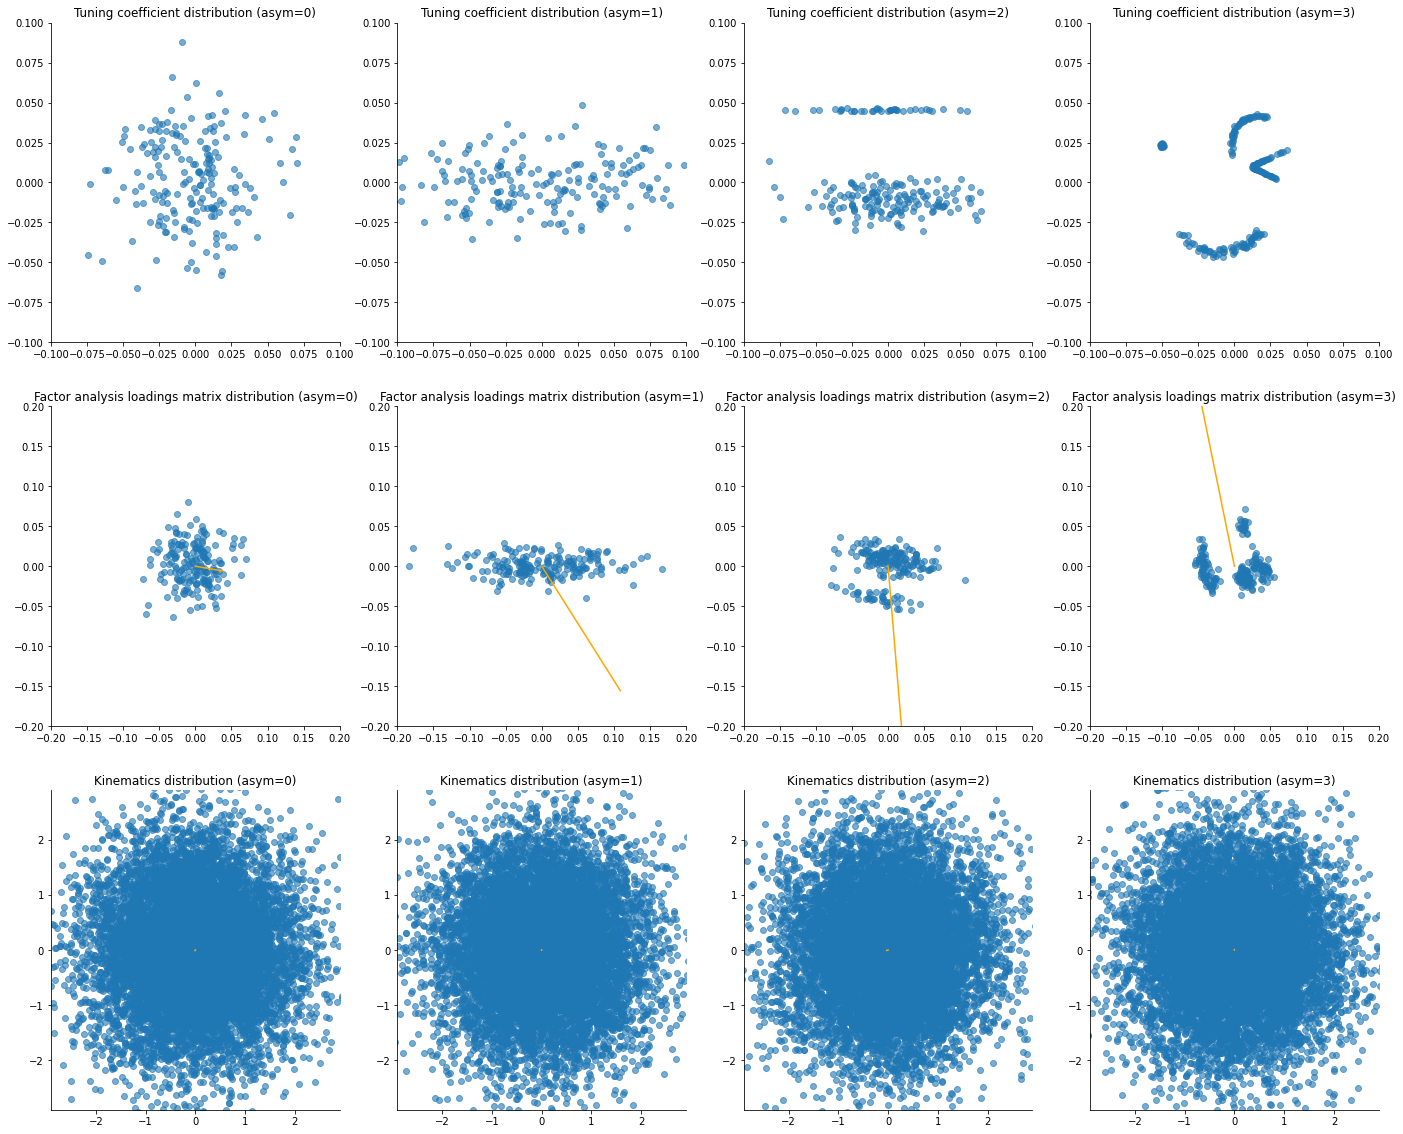

In [525]:
from sklearn.decomposition import FactorAnalysis, PCA
import scipy

np.random.seed(42)

figSize(20,30)

n_units = 192
SNR     = sampleSNR()
noise   = 0.3
lims    = np.asarray([-1, 1]) * 0.1



for i, asym_level in enumerate([0, 1, 2, 3]):

    # now generate asymmetric version
    asym_encoding = makeEncodingAsymmetric(n_units, SNR, strength=asym_level)
    neural_asym, kinematic_asym = simulateUnitActivity(asym_encoding, noise=noise, nSteps=10000)

    r2_asym = LinearRegression().fit(neural_asym, kinematic_asym).score(neural_asym, kinematic_asym)
    print(f'R2 asymmetric = {r2_asym}')

    # plot side-by-side to demonstrate channel tuning asymmetry
    plt.subplot(3,5,i+1)
    plt.scatter(asym_encoding[:, 1], asym_encoding[:, 2], alpha=0.6)
    plt.xlim(lims)
    plt.ylim(lims)
    plt.title(f'Tuning coefficient distribution (asym={asym_level})')
    
    skew = scipy.stats.skew(asym_encoding, axis=0)
    plt.plot([0, skew[0]], [0, skew[1]], color = 'orange')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # and plot distribution of neural activity in latent space:
    plt.subplot(3,5,i+1+5)
    
    fa_encoding = FactorAnalysis(n_components=2).fit(neural_asym).components_.T
    plt.scatter(fa_encoding[:,0], fa_encoding[:, 1], alpha=0.6)
    plt.xlim(lims * 2)
    plt.ylim(lims * 2)
    plt.title(f'Factor analysis loadings matrix distribution (asym={asym_level})')
    
    skew = scipy.stats.skew(fa_encoding, axis=0)
    plt.plot([0, skew[0]], [0, skew[1]], color = 'orange')
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    
    # now plot kinematics distribution to show no asymmetry
    plt.subplot(3,5,i+1+10)
    
    plt.scatter(kinematic_asym[:,0], kinematic_asym[:, 1], alpha=0.6)
    plt.xlim([-2.9, 2.9])
    plt.ylim([-2.9, 2.9])
    plt.title(f'Kinematics distribution (asym={asym_level})')
    
    skew = scipy.stats.skew(kinematic_asym, axis=0)
    plt.plot([0, skew[0]], [0, skew[1]], color = 'orange')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


## A fun diversion

Here we'll first show a fun fact: asymmetry helps procrustes realignment for certain types of linear dimensionality reduction.

We'll use an oval distribution of tuning coefficients to make this point. With PCA, the resulting loadings matrix has unit columns (PCA enforces this in the model). This means we *cannot recover the asymmetry* in this shape. By contrast, Factor Analysis (FA) does recover the oval, enabling better alignment in this simple toy example.

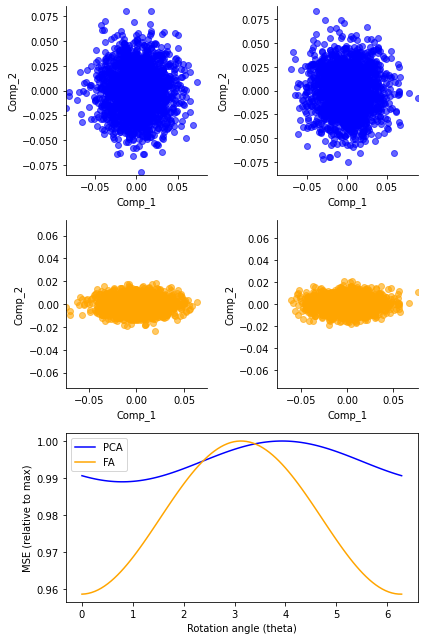

In [257]:
figSize(9,6)

colors = ['blue', 'orange']

loadings_fa = list()
loadings_pca = list()

# simulate neural tuning on two different days
for i in range(2):
    encoding = generateUnits(n_units=n_units * 10, SNR= SNR)
    encoding[:, 0] = 0

    asym_encoding = makeEncodingAsymmetric(encoding=encoding, strength=1)
    neural_asym, kinematic_asym = simulateUnitActivity(asym_encoding, noise=noise, nSteps=10000)
    
    loadings_pca.append(PCA(n_components=2).fit(neural_asym).components_.T)
    loadings_fa.append(FactorAnalysis(n_components=2).fit(neural_asym).components_.T)

    
for j, loadings in enumerate([loadings_pca, loadings_fa]):
    for i in range(2):    
        plt.subplot(3, 2, i+1 +(j*2))
        plt.scatter(loadings[i][:, 0], loadings[i][:, 1], alpha = 0.6, c= colors[j])
        lim = np.abs(loadings[i]).max()
        plt.xlim([-1 * lim, lim])
        plt.ylim([-1 * lim, lim])
        
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.xlabel('Comp_1')
        plt.ylabel('Comp_2')

    
rots = np.linspace(0, 2 * np.pi, 100)
mse_pca = np.zeros(rots.shape)
mse_fa  = np.zeros(rots.shape)
for i, rot in enumerate(rots):
    R       = np.asarray([[np.cos(rot), np.sin(rot)],[-1 * np.sin(rot), np.cos(rot)]])
    mse_pca[i] = np.linalg.norm(loadings_pca[0] - loadings_pca[1].dot(R))
    mse_fa[i]  = np.linalg.norm(loadings_fa[0] - loadings_fa[1].dot(R))
    
plt.subplot(3,1,3)
plt.plot(rots, mse_pca / mse_pca.max(), c = colors[0], label = 'PCA')
plt.plot(rots, mse_fa / mse_fa.max(), colors[1], label = 'FA')
plt.legend()
plt.xlabel('Rotation angle (theta)')
plt.ylabel('MSE (relative to max)')

plt.tight_layout()

TODO:
    - create a testStabilizer() fcn for below
    - add HP sweep over B, threshold parameter

In [550]:
from utils.recalibration.stabilizer_utils import Stabilizer


np.random.seed(42)

# Now introduce encoding shift via channel permutation and measure performance across strengths

B = 150
asym_levels = [0, 1, 2, 3]
reps        = 100 # reps per condition

dicts = list()
n_stable = encoding.shape[0] - n_permuted
print(f'{n_permuted}-channel alteration...')
for _ in range(reps):
    for i, asym_level in enumerate(asym_levels):

        # Generate asymmetric matrix:
        asym_encoding = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
        neural_asym, kinematic_asym = simulateUnitActivity(asym_encoding, noise=noise, nSteps=10000)   

        # Train decoder in FA latent space:
        stabilizer  = Stabilizer(n_components=2, model_type='FactorAnalysis').fit_ref([neural_asym])
        latent_asym = stabilizer.ref_model.transform(neural_asym) 

        decoder = LinearRegression().fit(latent_asym, kinematic_asym)
        r2_orig = decoder.score(latent_asym, kinematic_asym)

        # Create new tuning
        enc_altered = makeEncodingAsymmetric(n_units=n_units, SNR= SNR, strength=asym_level)
        enc_altered[:10, :] = asym_encoding[:10, :]
        neural_asym, kinematic_asym = simulateUnitActivity(enc_altered, noise=noise, nSteps=10000)

        # test old model on new data
        latents_asym = stabilizer.ref_model.transform(neural_asym)
        r2_drift     = decoder.score(latents_asym, kinematic_asym)
        preds_drift  = decoder.predict(latents_asym)
        corr_drift   = np.corrcoef(preds_drift.flatten(), kinematic_asym.flatten())[0, 1]

        # Test latent space decoder after applying FA stabilizer:
        stabilizer.fit_new([neural_asym], B=B, thresh=0.)
        neural_realigned = stabilizer.transform(neural_asym)
        r2_realigned     = decoder.score(neural_realigned, kinematic_asym)
        preds            = decoder.predict(neural_realigned)

        subspace_corr = np.corrcoef(enc_altered[:, 1:].flatten(), asym_encoding[:, 1:].flatten())[0,1]

        x_corr = np.corrcoef(preds.T, kinematic_asym.T)[0, 2]
        y_corr = np.corrcoef(preds.T, kinematic_asym.T)[1, 3]
        corr_realigned = np.corrcoef(preds.flatten(), kinematic_asym.flatten())[0,1]

        #upper bound from a subspace decoder trained on new neural data:
        #latents    = stabilizer.new_model.transform(neural_asym)
        best_preds = LinearRegression().fit(neural_asym, kinematic_asym).predict(neural_asym)
        x_best     = np.corrcoef(best_preds.T, kinematic_asym.T)[0, 2]
        y_best     = np.corrcoef(best_preds.T, kinematic_asym.T)[1, 3]

        example_dict = {
            'n_stable'    : B,
            'subspace_correlation' : subspace_corr,
            'asym_level'  : asym_level,
            'r2_orig'     : r2_orig,
            'r2_drift'    : r2_drift,
            'corr_drift'  : corr_drift,
            'r2_realigned': r2_realigned,
            'corr_realigned' : corr_realigned,
            'x_corr' : x_corr,
            'y_corr' : y_corr,
            'x_corr_norm' : x_corr / x_best,
            'y_corr_norm' : y_corr / y_best

        }

        dicts.append(example_dict)


0-channel alteration...


Text(0.5, 1.0, 'Rotated and orig')

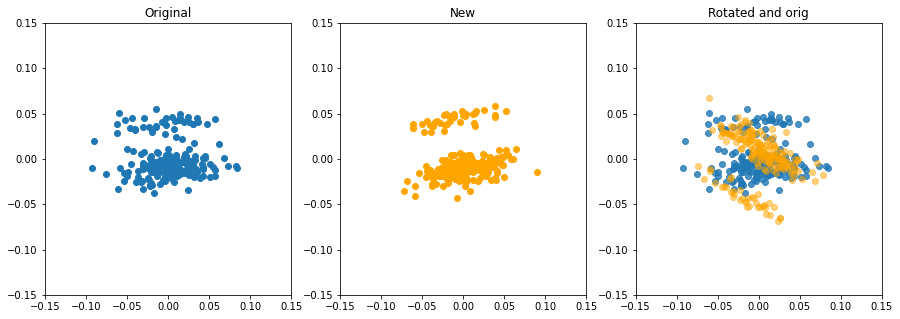

In [545]:
figSize(5, 15)
plt.subplot(1,3,1)
plt.scatter(stabilizer.ref_coefs[:, 0], stabilizer.ref_coefs[:, 1])
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('Original')

plt.subplot(1,3,2)
plt.scatter(stabilizer.new_coefs[:, 0], stabilizer.new_coefs[:, 1], color='orange')
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('New')

plt.subplot(1,3,3)
rotated = stabilizer.new_coefs.dot(stabilizer.R)
plt.scatter(stabilizer.ref_coefs[:, 0], stabilizer.ref_coefs[:, 1],alpha=0.8)
plt.scatter(rotated[:, 0], rotated[:, 1],color='orange',alpha=0.5)
plt.xlim([-0.15, 0.15])
plt.ylim([-0.15, 0.15])
plt.title('Rotated and orig')

-------Subspace correlation tests------
RanksumsResult(statistic=-0.36895172195604176, pvalue=0.7121637101960987)
RanksumsResult(statistic=1.3682977767906184, pvalue=0.17121888641309146)
RanksumsResult(statistic=1.519787887792437, pvalue=0.12856429423929383)
RanksumsResult(statistic=1.126402276965134, pvalue=0.25999528345102596)
RanksumsResult(statistic=1.1874869991432868, pvalue=0.2350355817041656)
RanksumsResult(statistic=-0.3249707219877719, pvalue=0.7452032305597869)

 -------post-drift decoder output correlations test------
RanksumsResult(statistic=1.3707411656777446, pvalue=0.17045565726071865)
RanksumsResult(statistic=1.8887396097484788, pvalue=0.05892672831242811)
RanksumsResult(statistic=-0.1661504443245751, pvalue=0.8680385569784177)
RanksumsResult(statistic=1.5564387210993285, pvalue=0.11960380364702317)
RanksumsResult(statistic=-0.3811686663916723, pvalue=0.7030780978183633)
RanksumsResult(statistic=-0.4471401663440771, pvalue=0.6547738594943762)


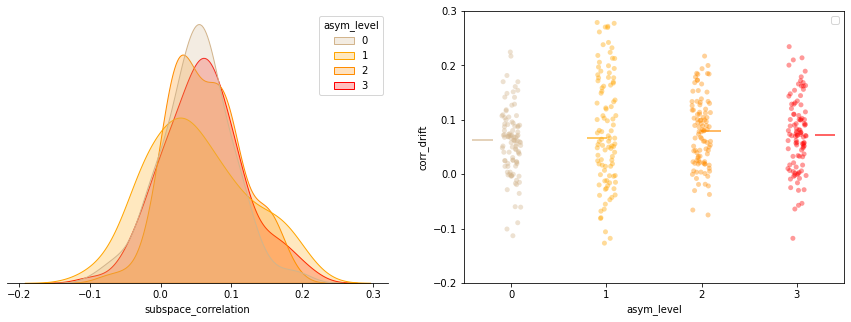

In [551]:
import pandas as pd, seaborn as sns

colors = ['tan', 'orange', 'darkorange', 'red']

figSize(5, 15)

df = pd.DataFrame(dicts)

plt.subplot(1,2,1)
sns.kdeplot(df, x='subspace_correlation',  hue='asym_level', palette=colors, fill=True)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
ax.set_ylabel(None)

plt.subplot(1,2,2)
ax = plt.gca()
sns.stripplot(df, x='asym_level', y='corr_drift', hue='asym_level', palette = colors,
              alpha = 0.4, ax = ax)

sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=df, x ='asym_level', y = 'corr_drift', showfliers=False, showbox=False, 
            showcaps=False, hue = 'asym_level', palette = colors, ax = ax)

for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[np.floor(i/3).astype(int)])

plt.legend([])
plt.ylim([-0.2, 0.3])


# now run stats on group differences:
print('-------Subspace correlation tests------')
for i in np.unique(df.asym_level):
    for j in np.unique(df.asym_level):
        if i > j:
            stats = scipy.stats.ranksums(df[df.asym_level == i]['subspace_correlation'],
                                         df[df.asym_level == j]['subspace_correlation'])
            print(stats)

print('\n -------post-drift decoder output correlations test------')
for i in np.unique(df.asym_level):
    for j in np.unique(df.asym_level):
        if i > j:
            stats = scipy.stats.ranksums(df[df.asym_level == i]['corr_drift'],df[df.asym_level == j]['corr_drift'])
            print(stats)

(-1.2, 1.2)

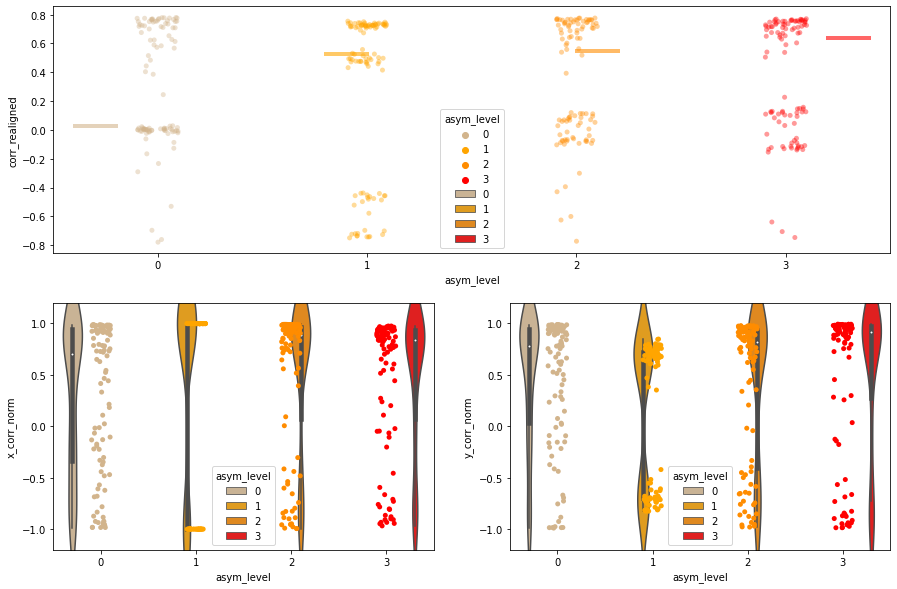

In [552]:
import pandas as pd, seaborn as sns


figSize(10, 15)

plt.subplot(2, 1, 1)
sns.stripplot(df, x='asym_level', y='corr_realigned', hue='asym_level', palette = colors,
              alpha = 0.4)

sns.boxplot(medianprops={'ls': '-', 'lw': 4, 'alpha' : 0.6}, whiskerprops={'visible': False},
            zorder=1, data=df, x ='asym_level', y = 'corr_realigned', showfliers=False, showbox=False, 
            showcaps=False, hue = 'asym_level', palette = colors)

for i, line in enumerate(plt.gca().get_lines()):
    line.set_color(colors[np.floor(i/3).astype(int)])

    


df = pd.DataFrame(dicts)


plt.subplot(2,2,3)
sns.violinplot(df, x='asym_level', y='x_corr_norm', hue='asym_level', palette = colors)
sns.stripplot(df, x='asym_level', y='x_corr_norm', hue='asym_level', palette = colors, legend=None)
plt.ylim([-1.2, 1.2])


plt.subplot(2,2,4)
sns.violinplot(df, x='asym_level', y='y_corr_norm', hue='asym_level', palette= colors)
sns.stripplot(df, x='asym_level', y='y_corr_norm', hue='asym_level', palette = colors, legend=None)

plt.ylim([-1.2, 1.2])

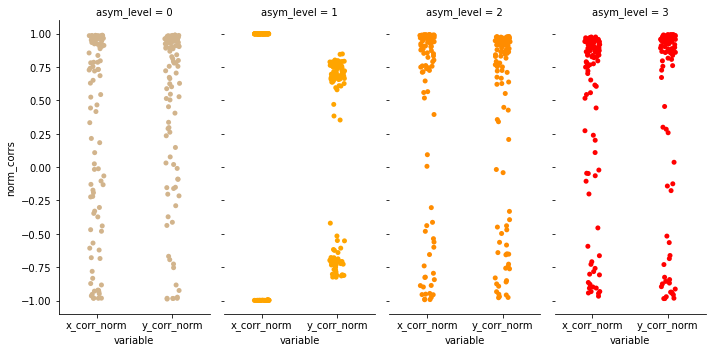

In [553]:
copy = df.copy()
copy = pd.melt(copy, id_vars = ['asym_level'], value_vars = ["x_corr_norm", "y_corr_norm"], value_name="norm_corrs")


#figSize(2, 2)
g = sns.catplot(data=copy, x="variable", y="norm_corrs", hue="asym_level", col="asym_level",
            palette = colors, aspect=.5)

for col_val, ax in g.axes_dict.items():
    if col_val > 0:
        ax.spines['left'].set_visible(False)

TypeError: makeEncodingAsymmetric() got an unexpected keyword argument 'encoding'

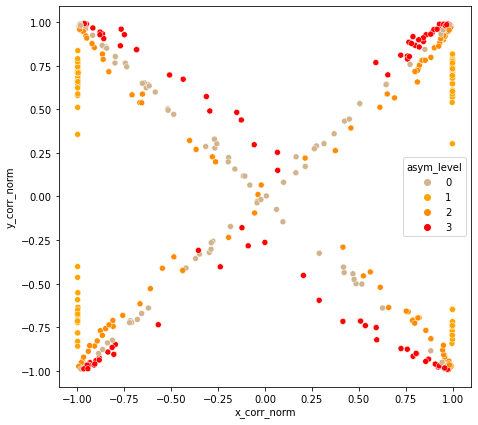

In [530]:
figSize(7, 10)


n_encodings = len(np.unique(df.asym_level)) 

lims = [-0.15, 0.15]

fig = plt.figure()

gs = fig.add_gridspec(n_encodings,n_encodings)
ax = fig.add_subplot(gs[:n_encodings, 1:])

sns.scatterplot(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', ax = ax, palette = colors)
#sns.jointplot(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', ax = ax, palette = colors)

#g = sns.JointGrid(df, x = 'x_corr_norm', y = 'y_corr_norm', hue = 'asym_level', palette = colors)
#g.plot(sns.scatterplot, sns.histplot, ax = ax,)

for i in range(n_encodings):
    encoding       = generateUnits(n_units=n_units, SNR= SNR)
    encoding[:, 0] = 0
    asym_encoding  = makeEncodingAsymmetric(encoding=encoding, strength=i)

    # plot side-by-side to demonstrate channel tuning asymmetry
    #plt.subplot(3,3,(i+1)*3)
    ax = fig.add_subplot(gs[i, 0])
    ax.scatter(asym_encoding[:, 1], asym_encoding[:, 2], alpha=0.6, c = colors[i])
    #plt.xlim(lims)
    #plt.ylim(lims)
    #ax.set_xticks(plt.xlim())
    #ax.set_yticks(plt.ylim())
    plt.title(f'Tuning coefficient distribution (asym={i})')
    
plt.tight_layout()
plt.show()

Results:

- asym_level = 0: model is randomly rotating the subspace axes around, so on average it doesn't do too well. As x-readout gets more accurate, y-readout can either get better or worse (depending on rotation angle) because of rigid transformation.

- asym_level = 1: y-axis has smaller encoding so it gets messed up a lot. but when kk, there are 4 clusters (x/y parallel, x parallel/y antiparallel, x antiparallel/y parallel, x/y antiparallel)

- asym_level = 2: y-axis is correct always because of asym, x-readout can either be parallel or antiparallel with x-encoding weights. Subset of days where alignment just totally fails (near 0 for both). 